In [1]:
%matplotlib inline
import os
import cv2
import json
import torch
import torchvision
from torch import nn
import pandas as pd
import numpy as np
from skimage import color, io
import matplotlib.pyplot as plt

from torchvision import transforms, models
from torchvision.datasets import MNIST
from torchsummary import summary

from sklearn.model_selection import KFold, train_test_split

from sklearn.datasets import make_regression
from torch.utils.data import Dataset, DataLoader, ConcatDataset,random_split,SubsetRandomSampler

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [2]:
##############################################################
# CLASS TO NORMALIZE OUR DATA
##############################################################

class Normalization(object):
    def __init__(self, mean, std):
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
    def __call__(self, sample):
        image, label1, label2, label3 = sample['image'],\
        sample['label_age'], sample['label_gender'], sample['label_race']
        
        return {'image': image,
                'label_age': label1,
                'label_gender': label2,
                'label_race': label3}

##############################################################
# CLASS FOR DATA HANDLING IN PYTORCH
##############################################################

class HumanoidData(Dataset):
    def __init__(self, image_tensor, annotations_tensor, train=True, transform=None):
        
        #Leaving only image related columns
        self.x =image_tensor.float()
        self.y = annotations_tensor.float()
        self.device = torch.device('cuda')
            
        #############################
        # TRANSFORMS
        #############################
        
        #Applying transformation
        self.transform=transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        image=self.x[idx]
        labels=self.y[idx]
        
        return (image,labels)

In [3]:
##############################################################
# LOAD TENSORS FROM FILES
##############################################################

device = torch.device('cuda')

annotations_tensor = torch.load('tensors/humans_monsters_annotation_tensor.pt', map_location=device)
plain_image_tensor = torch.load('tensors/humans_monsters_plain_image_tensor.pt', map_location=device)

#rgb_tensor = torch.load('tensors/humans_monsters_rgb_image_tensor.pt', map_location=device)
#texture_tensor = torch.load('tensors/humans_monsters_texture_image_tensor.pt', map_location=device)

##############################################################
# CREATE DATA OBJECTS AND PREPARE THEM FOR THE CNN WITH
# THE DATA LOADER CLASS
##############################################################

plain_dataset = HumanoidData(plain_image_tensor, annotations_tensor)
                       
print("Dataset/s loaded")

Dataset/s loaded


#### Original Architecture

* Input Layer: fixed image of size 200 x 200 x 1
* Second Layer: Convolution with 5-pixels square kernel. Output: feature map of size 196 x 196 x 8.

* RelU: The tensor is then passed through a ReLU and batch normalization is applied.

* Pooling Layer: Max pooling with stride 2 
* Convolution Layer: Convolution with 5-pixels square kernel and 16 output channels Output: Tensor of size 94 x 94 x 16.

* Pooling Layer: Max pooling with stride 2. And then flatten. Output: tensor of size 35344

* Fully Connected Layer:
* RelU: The tensor is then passed through a ReLU and batch normalization is applied.

* Regressor Layer: Output: 8 human body dimensions in meters

#### Training
* 20 epochs
* mini_batch_size = 100
* Loss = MSE
* learning_rate = 0.01
* momentum = 0.9
* TODO: regressor funktion
* For layers
* 
* https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

In [4]:
##############################################################
# CONVOLUTIONAL NEURAL NETWORK
##############################################################

class ConvNet(nn.Module):
    '''
    Simple Convolutional Neural Network
    '''
    def __init__(self):
        
        super().__init__()
        self.layers = nn.Sequential(

          # input layer 200 x 200 x 1 - (in: 1 color channel, out: 8 Channels, ...)
          # output 196 x 196 x 8  
          nn.Conv2d(1, 8, kernel_size=5),
          nn.ReLU(),
            
          # batch ormalization layer
          nn.LayerNorm((196, 196)),

          # input 196 x 196 x 8 
          # output 98 x 98 x 8
          nn.MaxPool2d(stride=2, kernel_size=1),

          # input 98 x 98 x 8
          # output 94 x 94 x 16
          nn.Conv2d(8, 16, kernel_size=5),
          nn.ReLU(),

          # input 94 x 94 x 16
          # output 47 x 47 x 16
          nn.MaxPool2d(stride=2, kernel_size=1),

          # Pooling Layer: Max pooling with stride 2. And then flatten.
          # Output: tensor of size 35344 = 47 x 47 x 16
          nn.Flatten(),
          nn.Linear(35344, 512),
          nn.ReLU(),

          # Last Layer - Regressor
          # input 35344
          # output 8
          nn.Linear(512, 8)

        )

    def forward(self, x):
        inputs = x.unsqueeze(1)
        outputs = self.layers(inputs)
        return outputs

In [5]:
##############################################################
# TRAIN LOOP
##############################################################

def train_loop(dataloader, model, loss_fn, optimizer):
    print("Train:")
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [6]:
##############################################################
# TEST LOOP
##############################################################

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    
    num_batches = len(dataloader)
    test_loss, correct, diff, diff_fracture = 0, 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(0) == y).type(torch.float).sum().item()
            diff += (abs(pred.argmax(0) - y)).type(torch.float).sum().item() #with or without argmax?
            diff_fracture += (abs(pred.argmax(0) - y)/y).type(torch.float).sum().item() #with or without argmax?

    test_loss /= num_batches
    correct /= size
    diff /= size
    diff_fracture /= size
    print(f"\nTest Error: \n AMAD: {(diff):>0.3f}%, \n ARPE: {(diff_fracture):>0.3f}%, \n Avg loss: {test_loss:>6f} \n")
    
    return test_loss

In [7]:
##############################################################
# HYPER PARAMETERS
##############################################################

# Loss Function
loss_fn = nn.MSELoss()

# Model of our Neural Network - push to GPU
model = ConvNet().to(device)
                     
# Use Stochastic Gradient Descent as function to optimize
learning_rate = 0.01
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

summary(model, (200, 200),1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 8, 196, 196]             208
              ReLU-2           [1, 8, 196, 196]               0
         LayerNorm-3           [1, 8, 196, 196]          76,832
         MaxPool2d-4             [1, 8, 98, 98]               0
            Conv2d-5            [1, 16, 94, 94]           3,216
              ReLU-6            [1, 16, 94, 94]               0
         MaxPool2d-7            [1, 16, 47, 47]               0
           Flatten-8                 [1, 35344]               0
            Linear-9                   [1, 512]      18,096,640
             ReLU-10                   [1, 512]               0
           Linear-11                     [1, 8]           4,104
Total params: 18,181,000
Trainable params: 18,181,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Fo

In [ ]:
##############################################################
# TRAIN NETWORK 
##############################################################

# Store AVG Loss for plotting
avg_losses = []

# Train Parameters
epochs = 20
k=5          # no_folds
batch_size = 100

# k-fold cross validation - 4 folds test, 1 fold train -> random state for replicable results
splits=KFold(n_splits=k,shuffle=True,random_state=42)

# k-fold cross validation - 4 folds test, 1 fold train
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(plain_dataset)))):
    
    # get samples from k fold
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(plain_dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(plain_dataset, batch_size=batch_size, sampler=test_sampler)

    # train epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer)
        avg_losses.append(test_loop(test_loader, model, loss_fn))

print("Done!")

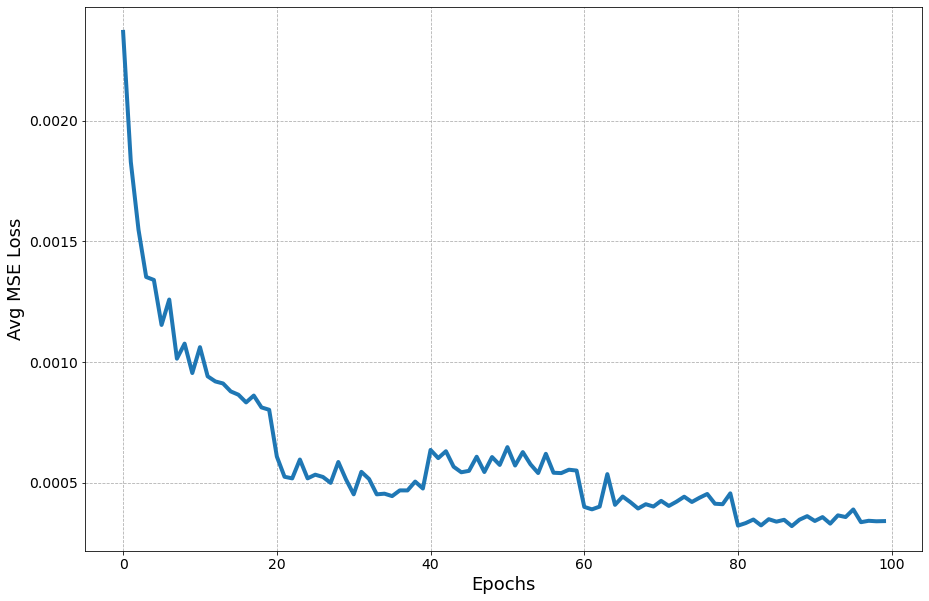

In [9]:
##############################################################
# PLOTS
##############################################################

#################################
# LOSS FUNCTION
#################################

plt.figure(figsize=(15, 10))
plt.plot(avg_losses, linewidth=4)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Avg MSE Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.grid(which='both', linestyle='--')
plt.show()